# retail_sales_forecast

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler,OneHotEncoder,FunctionTransformer
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, GRU, Dense, SimpleRNN, Flatten,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_log_error, mean_absolute_error


In [5]:
pd.set_option("display.float_format", "{:,.2f}".format)

## Importação da Base

In [6]:
# Google Colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
# os.chdir allows you to change directories, like cd in the Terminal
#os.chdir('/content/drive/MyDrive/Colab Notebooks/retail_sales_forecast')

df_data = pd.read_parquet('df_merged.parquet')

In [7]:
print(f'shape: {df_data.shape}')
display(df_data.head(0))
print(df_data.info())

shape: (3000888, 13)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday,transactions,dcoilwtico


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       object        
 10  holiday       object        
 11  transactions  float64       
 12  dcoilwtico    float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 297.6+ MB
None


In [8]:
df_data['chave'] = df_data['store_nbr'].astype('str') + df_data['family']
df_data['holiday'] = df_data['holiday'].astype('str')


In [9]:
# Number of sequences:
df_sequences = df_data['chave'].drop_duplicates()
n_sequences = df_sequences.count()
print(f'n_sequences: {n_sequences}')

n_sequences: 1782


In [10]:
# Number of observations:
n_observations = df_data.groupby('chave')[['sales']].count()
print(f'chave com quantidade de observações diferentes de {n_observations.iloc[0,0]}:')
display(n_observations[n_observations['sales']!=n_observations.iloc[0,0]])
n_observations = n_observations.iloc[0,0]
print('\n')
print(f'n_observations: {n_observations}')

chave com quantidade de observações diferentes de 1684:


,sales
chave,




n_observations: 1684


In [11]:
# Number of features:
print(f'columns: {df_data.columns}')
features = ['sales','onpromotion', 'city', 'state', 'type', 'cluster', 'holiday', 'dcoilwtico', 'transactions']
print(f'features: {features}')
n_features = len(features)
print(f'n_features: {n_features}')

columns: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'holiday', 'transactions', 'dcoilwtico',
       'chave'],
      dtype='object')
features: ['sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'holiday', 'dcoilwtico', 'transactions']
n_features: 9


## Seleção de amostras para teste
###### Redução de tempo de processamento para validação de modelo

In [12]:
# Seleção de top n sequencias para teste do modelo:

n = 10
df_sequences = df_data.groupby('chave')[['sales']].sum().sort_values(by='sales', ascending=False).head(n)
df_sequences = df_sequences.reset_index().drop(columns='sales')
df_sequences

,chave
0,44GROCERY I
1,45GROCERY I
2,47GROCERY I
3,46GROCERY I
4,44BEVERAGES
5,3GROCERY I
6,48GROCERY I
7,45BEVERAGES
8,3BEVERAGES
9,49GROCERY I


In [13]:
# Seleção das amostras
for sequence in df_sequences['chave']:
    df_data.loc[df_data['chave'] == sequence, 'chave_aux'] = 'x'

df_data = df_data[df_data['chave_aux'] == 'x']
df_data.drop(columns = 'chave_aux', inplace = True)
print(df_data.shape)

(16840, 14)


In [14]:
# 🔹 Garantir ordenação correta por respeitando ordenação do df_sequences e data
ordem = df_sequences['chave'].tolist()
df_data['ordem_personalizada'] = df_data['chave'].apply(lambda x: ordem.index(x))
df_data = df_data.sort_values(by=['ordem_personalizada', 'date']).drop(columns='ordem_personalizada')
#df_data['date'] = df_data['date'].astype('str')
df_data_input = df_data.copy(deep=True)

# 🔹 Parâmetros da Janela Temporal
WINDOW_SIZE = 120  # Número de dias usados como entrada
TARGET_DAYS = 16   # Número de dias a serem previstos
TRAIN_SPLIT = 0.91 # 80% treino, 20% teste

# 🔹 Criar função para gerar sequências de tempo
def create_sequences(data, window_size, target_days, target_column_idx):
    X, y = [], []
    for i in range(len(data) - window_size - target_days + 1):
        X.append(data[i:i+window_size])
        y.append(data[i + window_size : i + window_size + target_days, target_column_idx])

    return np.array(X), np.array(y)

# 🔹 Separação de treino/teste por loja e família
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# 🔹 Definir colunas numéricas e categóricas
y_col = ["sales"]
num_cols = ["onpromotion", "dcoilwtico","transactions"]
cat_cols = ["type", "city", "cluster", "holiday"]

# 🔹 Separar dados de treino e teste por chave (store_nbr + family)
df_train_list, df_test_list = [], []

store_family_groups = df_data_input.groupby(["store_nbr", "family"], sort = False)
for _, group in store_family_groups: # exemplo do output: (3, 'BEVERAGES'), dataframe
    group = group.sort_values("date")  # Garantir ordem temporal

    # Índice de separação (80% treino, 20% teste) garantindo sequência correta
    split_index = int(len(group) * TRAIN_SPLIT)

    df_train_list.append(group.iloc[:split_index])
    df_test_list.append(group.iloc[split_index:])

# 🔹 Concatenar para criar df_train e df_test final
df_train = pd.concat(df_train_list) # dataset com 80% das primeiras observações no treino
df_test = pd.concat(df_test_list) # dataset com 20% das observações no teste

'''
Como estou pre.fit somente no treino, a existencia das categorias no teste poderia ser um problema. Mas não são pois estou fazendo a divisão em treino e teste somente
nas observações dentro de cada chave. Cada chave possui um mesmo type, city e clustes. Holiday que pode vir a mudar, mas certamente teremos holidays e não holidays no
treino. Portanto, não deveria haver problema.
'''

# 🔹 Criar um pré-processador e ajustar **somente no conjunto de treino**
preprocessor = ColumnTransformer([
    ("y_col", RobustScaler(), y_col),
    ("num_cols", RobustScaler(), num_cols),
    ("cat_cols", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse_output=False), cat_cols)
])

preprocessor.fit(df_train[y_col + num_cols + cat_cols])  # .fit do preprocessamento apenas no treino

# 🔹 Obter nomes das features transformadas
feature_names = (
    preprocessor.named_transformers_["y_col"].get_feature_names_out(y_col).tolist() +
    preprocessor.named_transformers_["num_cols"].get_feature_names_out(num_cols).tolist() +
    preprocessor.named_transformers_["cat_cols"].get_feature_names_out(cat_cols).tolist()
)
target_column_idx = feature_names.index("sales")  # Localizar índice de "sales" para depois buscar pelo index no y

# 🔹 Criar sequências de treinamento e teste
store_family_groups_train = df_train.groupby(["store_nbr", "family"],sort = False)
store_family_groups_test = df_test.groupby(["store_nbr", "family"], sort = False)

for (_, train_group), (_, test_group) in zip(store_family_groups_train, store_family_groups_test): # junto as tuplas transformadas em um unico dataset
    # Garantir que ambos os conjuntos estão ordenados corretamente
    train_group = train_group.sort_values("date")
    test_group = test_group.sort_values("date")

    # Transformar os dados já normalizados
    train_features = preprocessor.transform(train_group[y_col + num_cols + cat_cols])
    test_features = preprocessor.transform(test_group[y_col + num_cols + cat_cols])

    # Criar sequências para treino e teste
    X_train_seq, y_train_seq = create_sequences(train_features, WINDOW_SIZE, TARGET_DAYS, target_column_idx)
    X_test_seq, y_test_seq = create_sequences(test_features, WINDOW_SIZE, TARGET_DAYS, target_column_idx)

    X_train_list.append(X_train_seq)
    X_test_list.append(X_test_seq)
    y_train_list.append(y_train_seq)
    y_test_list.append(y_test_seq)

# 🔹 Concatenar todas as séries
X_train = np.vstack(X_train_list)
X_test = np.vstack(X_test_list)
y_train = np.vstack(y_train_list)
y_test = np.vstack(y_test_list)

# 🔹 Exibir dimensões finais
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (13970, 120, 11)
X_test shape: (170, 120, 11)
y_train shape: (13970, 16)
y_test shape: (170, 16)


In [143]:
# do ~end_sequence~ para o ~end_sequence+1~, se muda a chave considerada, ou seja, caminha-se pelas 1684 observações e vai de uma chave para a outra
end_sequence = len(train_features) - WINDOW_SIZE - TARGET_DAYS
print(end_sequence)
pd.DataFrame(X_train[end_sequence,:,:], columns = preprocessor.get_feature_names_out())

1396


,y_col__sales,num_cols__onpromotion,num_cols__dcoilwtico,num_cols__transactions,cat_cols__type_D,cat_cols__city_Quito,cat_cols__cluster_11,cat_cols__cluster_14,cat_cols__cluster_5,cat_cols__cluster_8,cat_cols__holiday_1.0
0,0.39,2.89,-0.23,0.30,0.00,1.00,0.00,0.00,1.00,0.00,0.00
1,0.73,2.89,-0.23,0.71,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2,1.94,3.33,-0.26,1.68,0.00,1.00,0.00,0.00,1.00,0.00,1.00
3,0.89,3.37,-0.27,0.67,0.00,1.00,0.00,0.00,1.00,0.00,1.00
4,1.35,3.15,-0.28,0.87,0.00,1.00,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...
115,0.83,2.63,-0.08,0.99,0.00,1.00,0.00,0.00,1.00,0.00,0.00
116,1.40,2.63,-0.08,1.05,0.00,1.00,0.00,0.00,1.00,0.00,0.00
117,0.89,2.48,-0.08,0.39,0.00,1.00,0.00,0.00,1.00,0.00,0.00
118,0.82,2.59,-0.08,0.47,0.00,1.00,0.00,0.00,1.00,0.00,1.00


### Modelo 01

In [16]:
n_epochs = 2
n_patience = 5
n_batch_size = 32

In [17]:

%%time
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[2])),
    #Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh'),
    #Dropout(0.2),
    Dense(TARGET_DAYS)  # Saída com 16 valores (previsão para 16 dias)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.005)
             )

early_stopping = EarlyStopping(monitor='val_loss', patience=n_patience, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=n_epochs,
    batch_size=n_batch_size,
    callbacks=[early_stopping]
)

2025-04-08 12:28:20.304769: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/cesmarinho/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
437/437 ━━━━━━━━━━━━━━━━━━━━ 123s 276ms/step - loss: 0.4675 - val_loss: 0.1895
Epoch 2/2
437/437 ━━━━━━━━━━━━━━━━━━━━ 141s 322ms/step - loss: 0.2347 - val_loss: 0.1108
CPU times: user 10min 48s, sys: 3min 55s, total: 14min 44s
Wall time: 4min 24s


In [18]:
y_pred_scaled = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


In [19]:
y_pred_original = preprocessor.named_transformers_['y_col'].inverse_transform(y_pred_scaled)
y_test_original = preprocessor.named_transformers_['y_col'].inverse_transform(y_test)

In [20]:
print(y_test_original.shape)
y_test_original[15]

(170, 16)


array([14472.,  9934., 10941., 11156.,  8419.,  9346., 12463., 13248.,
        8497.,  8201.,  8062.,  7097.,  9979.,  9391.,  9811.,  8318.])

In [21]:
from sklearn.metrics import mean_absolute_error
mae_original = mean_absolute_error(y_test_original, y_pred_original)
print(f"MAE na escala original: {mae_original:.2f}")

MAE na escala original: 1058.06


In [22]:
rmsle = np.sqrt(mean_squared_log_error(y_test_original, y_pred_original))
print(f"RMSLE na escala original: {rmsle:.2f}")

RMSLE na escala original: 0.14


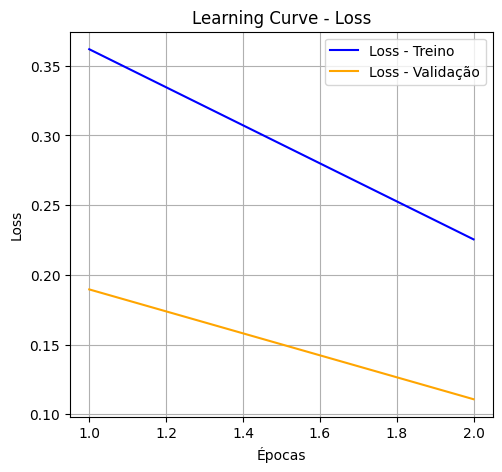

In [23]:
# Recuperar valores do histórico
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history.get('mae', None)  # Algumas vezes pode ser 'mean_absolute_error'
val_mae = history.history.get('val_mae', None)

epochs = range(1, len(loss) + 1)

# 🔹 Plotando Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Loss - Treino', color='blue')
plt.plot(epochs, val_loss, label='Loss - Validação', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid()

# 🔹 Plotando MAE (se disponível)
if mae is not None:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, label='MAE - Treino', color='blue')
    plt.plot(epochs, val_mae, label='MAE - Validação', color='orange')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.title('Learning Curve - MAE')
    plt.legend()
    plt.grid()

plt.show()

### Modelo 02

In [24]:
%%time
model_2 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[2])),
    #Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh'),
    #Dropout(0.2),
    Dense(TARGET_DAYS)  # Saída com 16 valores (previsão para 16 dias)
])

model_2.compile(loss='mse',
              optimizer=RMSprop(learning_rate=0.005)
             )

early_stopping = EarlyStopping(monitor='val_loss', patience=n_patience, restore_best_weights=True)

history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=n_epochs,
    batch_size=n_batch_size,
    callbacks=[early_stopping]
)

Epoch 1/2


/home/cesmarinho/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 146s 328ms/step - loss: 0.5190 - val_loss: 0.1353
Epoch 2/2
437/437 ━━━━━━━━━━━━━━━━━━━━ 139s 317ms/step - loss: 0.2551 - val_loss: 0.1254
CPU times: user 12min 18s, sys: 4min 37s, total: 16min 55s
Wall time: 4min 44s


In [25]:
y_pred_scaled_m2 = model_2.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


In [26]:
y_pred_original_m2 = preprocessor.named_transformers_['y_col'].inverse_transform(y_pred_scaled_m2)

In [27]:
mae_original_m2 = mean_absolute_error(y_test_original, y_pred_original_m2)
print(f"MAE na escala original: {mae_original_m2:.2f}")

MAE na escala original: 1142.69


In [28]:
rmsle_m2 = np.sqrt(mean_squared_log_error(y_test_original, y_pred_original_m2))
print(f"RMSLE na escala original: {rmsle_m2:.2f}")

RMSLE na escala original: 0.15


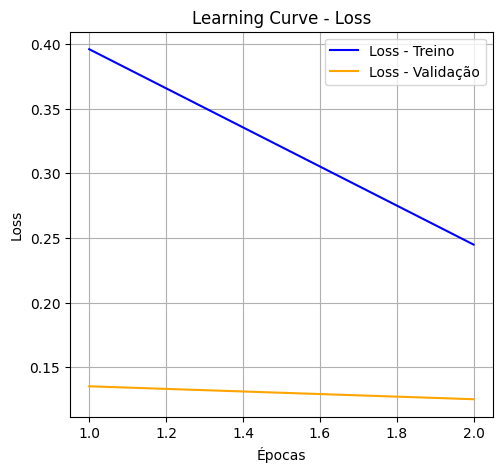

In [29]:
# Recuperar valores do histórico
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
mae = history_2.history.get('mae', None)  # Algumas vezes pode ser 'mean_absolute_error'
val_mae = history_2.history.get('val_mae', None)

epochs = range(1, len(loss) + 1)

# 🔹 Plotando Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Loss - Treino', color='blue')
plt.plot(epochs, val_loss, label='Loss - Validação', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid()

# 🔹 Plotando MAE (se disponível)
if mae is not None:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, label='MAE - Treino', color='blue')
    plt.plot(epochs, val_mae, label='MAE - Validação', color='orange')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.title('Learning Curve - MAE')
    plt.legend()
    plt.grid()

plt.show()

### Modelo 03

In [30]:
%%time
model_3 = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[2])),
    #Dropout(0.2),
    GRU(128, activation='tanh', return_sequences=True),
    GRU(64, activation='tanh', return_sequences=True),
    GRU(32, activation='tanh'),
    #Dropout(0.2),
    Dense(TARGET_DAYS)  # Saída com 16 valores (previsão para 16 dias)
])

model_3.compile(loss='mse',
              optimizer=RMSprop(learning_rate=0.005)
             )

early_stopping = EarlyStopping(monitor='val_loss', patience=n_patience, restore_best_weights=True)

history_3 = model_3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=n_epochs,
    batch_size=n_batch_size,
    callbacks=[early_stopping]
)

/home/cesmarinho/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
437/437 ━━━━━━━━━━━━━━━━━━━━ 144s 323ms/step - loss: 0.4388 - val_loss: 0.2000
Epoch 2/2
437/437 ━━━━━━━━━━━━━━━━━━━━ 141s 324ms/step - loss: 0.2412 - val_loss: 0.1849
CPU times: user 13min 32s, sys: 5min 9s, total: 18min 42s
Wall time: 4min 46s


In [31]:
y_pred_scaled_m3 = model_3.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


In [32]:
y_pred_original_m3 = preprocessor.named_transformers_['y_col'].inverse_transform(y_pred_scaled_m3)

In [33]:
mae_original_m3 = mean_absolute_error(y_test_original, y_pred_original_m3)
print(f"MAE na escala original: {mae_original_m3:.2f}")

MAE na escala original: 1319.60


In [34]:
rmsle_m3 = np.sqrt(mean_squared_log_error(y_test_original, y_pred_original_m3))
print(f"RMSLE na escala original: {rmsle_m3:.2f}")

RMSLE na escala original: 0.17


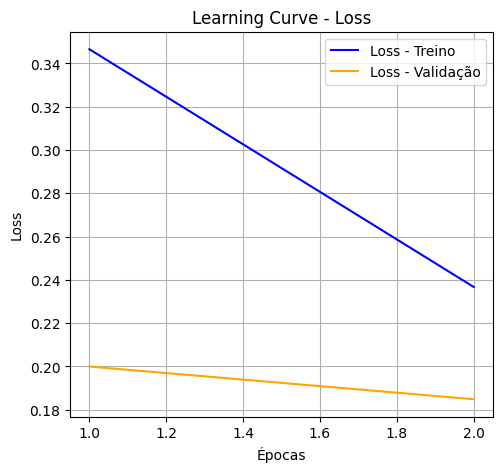

In [35]:
# Recuperar valores do histórico
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
mae = history_3.history.get('mae', None)  # Algumas vezes pode ser 'mean_absolute_error'
val_mae = history_3.history.get('val_mae', None)

epochs = range(1, len(loss) + 1)

# 🔹 Plotando Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Loss - Treino', color='blue')
plt.plot(epochs, val_loss, label='Loss - Validação', color='orange')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.grid()

# 🔹 Plotando MAE (se disponível)
if mae is not None:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, label='MAE - Treino', color='blue')
    plt.plot(epochs, val_mae, label='MAE - Validação', color='orange')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.title('Learning Curve - MAE')
    plt.legend()
    plt.grid()

plt.show()

### Best Model

In [36]:
df_models = pd.DataFrame([[mae_original, mae_original_m2, mae_original_m3],[rmsle, rmsle_m2, rmsle_m3],[y_pred_original, y_pred_original_m2, y_pred_original_m3]], columns = ['Modelo 01', 'Modelo 02', 'Modelo 03'], index = ['MAE', 'RMSLE', 'y_pred_original'])
df_models

,Modelo 01,Modelo 02,Modelo 03
MAE,"1,058.06","1,142.69","1,319.60"
RMSLE,0.14,0.15,0.17
y_pred_original,"[[15184.115, 17136.781, 10458.169, 9775.297, 9...","[[13426.025, 14306.021, 9476.331, 9364.569, 93...","[[14148.752, 15444.307, 9448.783, 8102.9053, 7..."


In [37]:
best_model_mae = df_models.loc['MAE'].min()
best_model = df_models.loc['MAE'].idxmin()
best_model_rmsle = df_models.loc['RMSLE', best_model]
best_model_y_pred = df_models.loc['y_pred_original', best_model]

print(f"O {best_model} é o melhor, com MAE {best_model_mae:.2f} e RMSLE {best_model_rmsle:.2f}")

O Modelo 01 é o melhor, com MAE 1058.06 e RMSLE 0.14


### Dataframe das 16 observações finais

In [122]:
# ultimas 16 observações de cada seguencia, retornando ao shape esperado do y (n_sequences, n_observations):
def y_shape_10_16(y, train_test_df, window_size, target_days):
    y_final = []
    # do ~end_sequence - 1~ para o ~end_sequence~, se muda a chave considerada, ou seja, caminha-se pelas 1684 observações e vai de uma chave para a outra
    end_sequence_y = len(train_test_df) - window_size - target_days + 1
    for i in range(end_sequence_y, int(y.shape[0]+1), end_sequence_y):
        print(i)
        print('\n')
        y_final.append(y[i - 1,:])
    return np.array(y_final)


In [133]:
best_model_y_pred[15,:]

array([17054.5   , 10846.442 ,  9741.863 , 10656.854 ,  8365.352 ,
       10296.696 , 14307.334 , 15505.468 ,  8956.3125,  8345.971 ,
       10121.352 ,  7810.6274, 10629.092 , 14448.773 , 16040.245 ,
       10040.949 ], dtype=float32)

In [124]:
best_model_y_pred.shape

(170, 16)

In [123]:
# Criação do tensor do y predict
y_pred_final = y_shape_10_16(best_model_y_pred, test_features, WINDOW_SIZE,TARGET_DAYS)
print(f'y_pred_final: {y_pred_final.shape}')

# Criação do tensor do y teste
y_test_final = y_shape_10_16(y_test_original, test_features, WINDOW_SIZE,TARGET_DAYS)
print(f'y_test_final: {y_test_final.shape}')

17


34


51


68


85


102


119


136


153


170


y_pred_final: (10, 16)
17


34


51


68


85


102


119


136


153


170


y_test_final: (10, 16)


In [112]:
# Criação  do dataframe final com o n_sequences:

def df_final(y, df_sequences, df_test):
    for i in range(int(y.shape[0])):
        if i == 0:
            df = pd.DataFrame(y[i], columns = ['sales'])
            df['chave'] = df_sequences['chave'][i]
            df['date'] = df_test['date'][-16:].values
        else:
            df_i =  pd.DataFrame(y[i],columns = ['sales'])
            df_i['chave'] = df_sequences['chave'][i]
            df_i['date'] = df_test['date'][-16:].values
            df = pd.concat([df, df_i], axis=0)
    return df


In [113]:
df_y_pred = df_final(y_pred_final, df_sequences, df_test)
df_y_pred.to_excel("df_y_pred.xlsx", index=False, sheet_name="df_y_pred")
df_y_pred

/tmp/ipykernel_1009/1888002956.py:2: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df_y_pred.to_excel("df_y_pred.xlsx", index=False, sheet_name="df_y_pred")


,sales,chave,date
0,"10,380.05",44GROCERY I,2017-07-31
1,"9,581.69",44GROCERY I,2017-08-01
2,"9,553.21",44GROCERY I,2017-08-02
3,"8,570.33",44GROCERY I,2017-08-03
4,"10,041.37",44GROCERY I,2017-08-04
...,...,...,...
11,"7,822.24",49GROCERY I,2017-08-11
12,"9,809.77",49GROCERY I,2017-08-12
13,"10,443.14",49GROCERY I,2017-08-13
14,"7,780.53",49GROCERY I,2017-08-14


In [114]:
df_y_test = df_final(y_test_final, df_sequences, df_test)
df_y_test.to_excel("df_y_test.xlsx", index=False, sheet_name="df_y_test")
df_y_test

/tmp/ipykernel_1009/3928175057.py:2: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df_y_test.to_excel("df_y_test.xlsx", index=False, sheet_name="df_y_test")


,sales,chave,date
0,"9,934.00",44GROCERY I,2017-07-31
1,"10,941.00",44GROCERY I,2017-08-01
2,"11,156.00",44GROCERY I,2017-08-02
3,"8,419.00",44GROCERY I,2017-08-03
4,"9,346.00",44GROCERY I,2017-08-04
...,...,...,...
11,"7,680.00",49GROCERY I,2017-08-11
12,"7,030.00",49GROCERY I,2017-08-12
13,"7,655.00",49GROCERY I,2017-08-13
14,"7,366.00",49GROCERY I,2017-08-14


FIM

In [115]:
df_y_test[df_y_test['chave'] == '44GROCERY I']

,sales,chave,date
0,"9,934.00",44GROCERY I,2017-07-31
1,"10,941.00",44GROCERY I,2017-08-01
2,"11,156.00",44GROCERY I,2017-08-02
3,"8,419.00",44GROCERY I,2017-08-03
4,"9,346.00",44GROCERY I,2017-08-04
5,"12,463.00",44GROCERY I,2017-08-05
6,"13,248.00",44GROCERY I,2017-08-06
7,"8,497.00",44GROCERY I,2017-08-07
8,"8,201.00",44GROCERY I,2017-08-08
9,"8,062.00",44GROCERY I,2017-08-09


In [116]:
df_y_pred[df_y_pred['chave'] == '44GROCERY I']

,sales,chave,date
0,"10,380.05",44GROCERY I,2017-07-31
1,"9,581.69",44GROCERY I,2017-08-01
2,"9,553.21",44GROCERY I,2017-08-02
3,"8,570.33",44GROCERY I,2017-08-03
4,"10,041.37",44GROCERY I,2017-08-04
5,"14,843.89",44GROCERY I,2017-08-05
6,"15,501.89",44GROCERY I,2017-08-06
7,"9,187.09",44GROCERY I,2017-08-07
8,"8,139.55",44GROCERY I,2017-08-08
9,"8,638.38",44GROCERY I,2017-08-09


In [117]:
best_model_y_pred[16,:]

array([10380.054,  9581.691,  9553.21 ,  8570.327, 10041.371, 14843.89 ,
       15501.893,  9187.094,  8139.554,  8638.377,  8504.499,  9696.243,
       15037.367, 15484.383, 10005.206,  8794.534], dtype=float32)

In [118]:
y_test_original[16,:]

array([ 9934., 10941., 11156.,  8419.,  9346., 12463., 13248.,  8497.,
        8201.,  8062.,  7097.,  9979.,  9391.,  9811.,  8318.,  8123.])

In [119]:
end_seq = len(test_features) - WINDOW_SIZE - TARGET_DAYS + 1
end_seq

17

In [121]:
_ = pd.read_csv('raw_data/train.csv')
aux = _[(_['store_nbr'] == 44) & (_['family']=='GROCERY I')]
aux.iloc[-16:][['date', 'sales']]

,date,sales
2973642,2017-07-31,"9,934.00"
2975424,2017-08-01,"10,941.00"
2977206,2017-08-02,"11,156.00"
2978988,2017-08-03,"8,419.00"
2980770,2017-08-04,"9,346.00"
2982552,2017-08-05,"12,463.00"
2984334,2017-08-06,"13,248.00"
2986116,2017-08-07,"8,497.00"
2987898,2017-08-08,"8,201.00"
2989680,2017-08-09,"8,062.00"


In [145]:
rmsle_m4 = np.sqrt(mean_squared_log_error(np.array(df_y_test[df_y_test['chave'] == '44GROCERY I']['sales']), np.array(df_y_pred[df_y_pred['chave'] == '44GROCERY I']['sales'])))
print(f"RMSLE na escala original: {rmsle_m4:.2f}")

RMSLE na escala original: 0.20
